In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sc
import sklearn as sk
import sklearn.covariance as skc
import graph_helpers as gh

%load_ext autoreload
%autoreload 2

In [6]:
def remove_diag(M):
    return M - np.diag(np.diag(M))

In [21]:
def confusion_result(P0,P1):
    n,p = P0.shape
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    tol = 1e-3
    for i in range(n):
        for j in range(i):
            if abs(P0[i,j])>tol and abs(P1[i,j])>tol:  #les 2 ont une arete
                TP +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])<tol:  #les 2 n'ont pas d'arete
                TN +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])>tol:  # arete trouvée dans P1 mais pas dasn P0
                FP +=1
            else:
                FN +=1  #arete presente dans P0 mais dasn P1
    return(TP, FP, TN, FN)

# graphical lasso

On considère $n$ observations $x_{1},x_{2},\ldots ,x_{n}$. On s'interesse à l'estimation d'une matrice de précision $P_0 = C_0^{-1}$. Si on fait l'hypothèse que les $x_i$ sont tirés aléatoirement suivant un va gaussienne $Z  \sim \mathcal{N}(0,C_0)$, on espère que le $C_1= P_1^{-1}$ obtenu est une bonne estimation de la matrice de covariance $C_0$ de $Z$. 

Le graphical lasso résout
$$\operatorname {argmin} _{P \geq 0} \operatorname {tr} (C P )-\log \det(P )+\lambda \sum _{j\neq k}|P _{jk}|$$

où $C$ est la covariance des échantillons, et $\lambda$ est le paramètre de pénalisation.

Nous allons tester le graphical lasso sur les différentes formes de graphes synthétisés afin d'évaluer ses performances.

In [633]:
# on définit un graphe par sa matrice de précision
num_vertices = 49
a = .8  # corrélation minimum 
name = "ligne"
name = "cyclique"
name = "kvoisin"
name = "grilleCarree" #cyclique ou grilleCarree ou kvoisin
A,Vx,Vy = gh.init_graph(name,num_vertices)

U = np.triu((1-a)*np.random.rand(num_vertices,num_vertices) + a)  # bruit balnc entre a et 1 
U=U+U.T    # Pour que Q soit symétrique
Q = A*U    # matrice de graphe pondéré
assert np.linalg.norm(Q-Q.T)<1e-6, "Q n'est pas symétrique !"

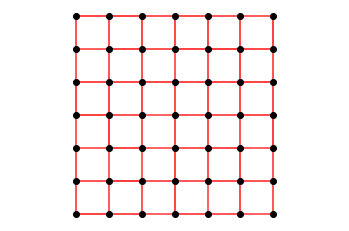

In [634]:
gh.dessin_graphe(Q,Vx,Vy)

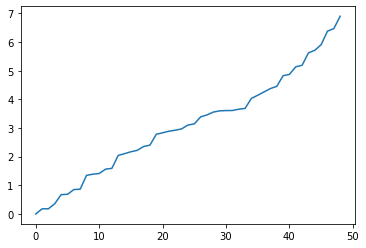

In [635]:
L = np.diag(np.sum(Q, axis = 0)) - Q
plt.plot(np.sort(np.linalg.eigvals(L)))

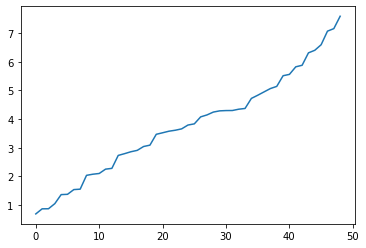

In [636]:
#Pour générer des vecteurs gaussiens de matrice l'inverse de L, L doit être inversible, 
#ce qui n'est pas forcément le cas. On modifie L pour avoir des vp positives
# c est un paramètre qui permet de jouer sur le conditionnement de la matrice de précision

c = 0.1   #10% de la vp maximale est ajoutée à la diagonale
E = np.linalg.eigvals(L)
sigma = c*np.max(E)
P0 = L + sigma*np.eye(num_vertices) 

plt.plot(np.sort(np.linalg.eigvals(P0)))

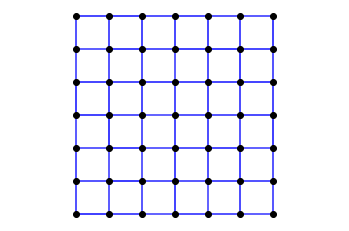

In [637]:
gh.dessin_graphe(P0,Vx,Vy)

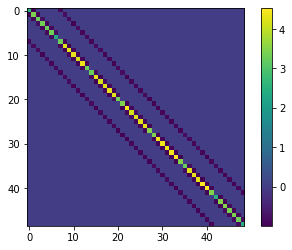

In [638]:
plt.imshow(P0)
plt.colorbar()

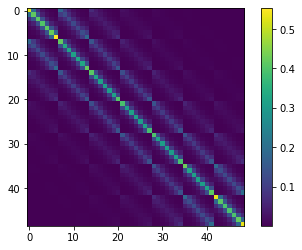

In [639]:
C0 = np.linalg.inv(P0)
plt.imshow(C0)
plt.colorbar()

Pour générer des vecteurs gaussiens de matrice de covariance $C_0$ : 

`w = randn(num_vertices,1)` réalisation d'un vecteur gaussien de moyenne nulle et de covariance $I_{m\times m}$ (soit $E(ww^T) = I_{m\times m}$ ($m=$`num_vertices`)

Soit $A$ matrice telle que $Z = Aw$. On a alors  Cov($Z$) = $E(ZZ^T) = E(Aw(Aw)^T) = A E(ww^T)A^T = AA^T$. Pour générer des vecteurs gaussiens de matrice de covariance $C_0$ soit $AA^T$, on peut choisir $A = C_0^{\frac{1}{2}}$ car $C_0$ positive.

In [640]:
n = 1000 # nombre d'échantillons
# on génére des va gaussiens de moyenne nulle et de matrice de covariance C0
X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,n)).T
#covariance empirique des échantillons
C = X.T@X/n

Dessine un signal généré.

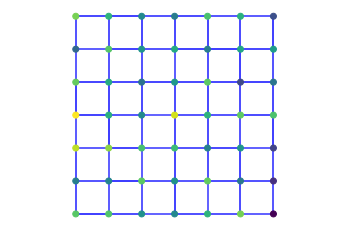

In [641]:
gh.dessin_graphe(P0,Vx,Vy,X[0,:])

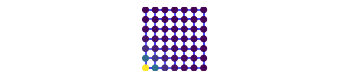

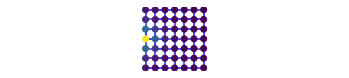

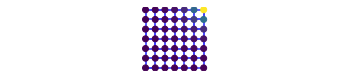

In [642]:
plt.subplot(3,1,1)
gh.dessin_graphe(P0,Vx,Vy,C0[0,:])
plt.subplot(3,1,2)
gh.dessin_graphe(P0,Vx,Vy,C0[num_vertices//2-3,:])
plt.subplot(3,1,3)
gh.dessin_graphe(P0,Vx,Vy,C0[-1,:])

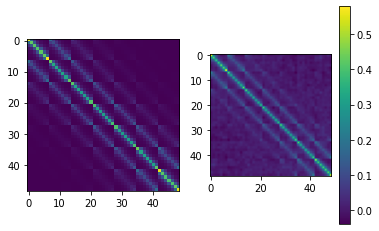

In [643]:
plt.subplot(1,2,1)
plt.imshow(C0)
plt.subplot(1,2,2)
plt.imshow(C)
plt.colorbar()

In [652]:
lamda = 0.1
C1,P1 = skc.graphical_lasso(C,lamda)

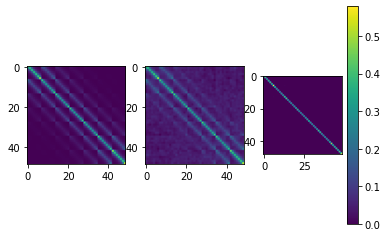

In [649]:
plt.subplot(1,3,1)
plt.imshow(C0)
plt.subplot(1,3,2)
plt.imshow(C)
plt.subplot(1,3,3)
plt.imshow(C1)
plt.colorbar()

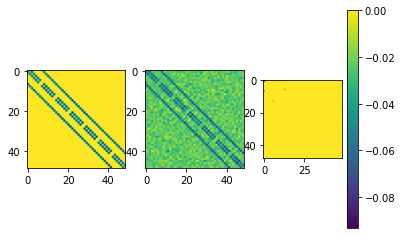

In [650]:
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(np.linalg.inv(C)))
plt.subplot(1,3,3)
plt.imshow(remove_diag(P1))
plt.colorbar()

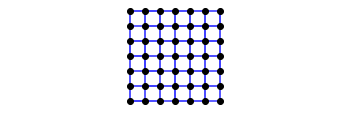

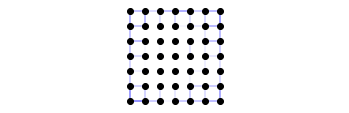

In [653]:
plt.subplot(2,1,1)
gh.dessin_graphe(P0,Vx,Vy)
plt.subplot(2,1,2)
gh.dessin_graphe(P1,Vx,Vy)

# score avec norme L1

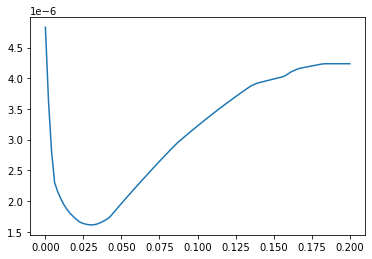

In [452]:
scoreL1 = []
L = list(np.linspace(1e-4,0.2,100))
for lamda in L:
    C1,P1 = skc.graphical_lasso(C,lamda)
    scoreL1.append(np.linalg.norm(P0-P1,1)/n**2)
plt.plot(L,scoreL1)

# norme L1 et barre d'erreur

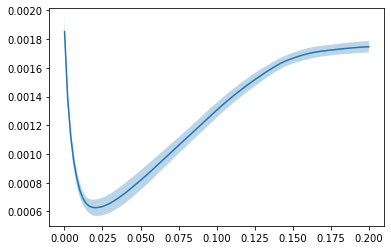

In [453]:
scoreL1 = []
L = list(np.linspace(1e-4,0.2,100))
nrep = 20 
for i in range(nrep):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        score.append(np.linalg.norm(P0-P1,1)/num_vertices**2)
    scoreL1.append(score)

M = np.mean(scoreL1, axis=0)  
S = np.std(scoreL1, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

# score avec "norme 0"

In [523]:
P0 = np.array([[1,1,1],[1,0,0],[1,0,1]])
P1 = np.array([[1,0,1],[0,0,0],[1,0,1]])
print(confusion_result(P0,P1))

(1, 0, 1, 1)


18

In [829]:
score01 = []
L = list(np.linspace(1e-4,0.2,100))
nrep = 20 
for i in range(nrep):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        TP, FP, TN, FN = confusion_result(P0,P1) 
        sc = (FP+FN)/num_vertices**2
        nb_edge = np.sum( remove_diag(P0).flatten()!=0 ) # nombre d'arretes dans P0
        sc = (FP+FN)/nb_edge
        score.append(sc)
    score01.append(score)

M = np.mean(score01, axis=0)  
S = np.std(score01, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

AttributeError: 'numpy.float64' object has no attribute 'linalg'

Meilleur $\lambda$ pour norme L0 pour $n = 1000$ et $m = 49$: $\lambda = 0.1$

In [457]:
n = 1000 
X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,n)).T
C = X.T@X/n

lamda = 0.1
C1,P1 = skc.graphical_lasso(C,lamda)
scoreL1 = np.linalg.norm(P0-P1,1)/num_vertices**2
print("scoreL1 = ",scoreL1)
TP, FP, TN, FN = confusion_result(P0,P1) 
scoreL0 = (FP+FN)/num_vertices**2
print("scoreL0_GL = ",scoreL0)

scoreL1 =  0.0012135112551391722
scoreL0_GL =  0.006663890045814244


# score ROC-AUC 

# comparaison avec méthode du TP6 : seuillage des éléments de la matrice de corrélation plutot que graphical lasso

In [458]:
correlation_threshold = 0.2
C2 = np.where(C > correlation_threshold, C, 0.0)

In [459]:
scoreL1 = np.linalg.norm(P0-C2,1)/n**2
print("scoreL1 = ",scoreL1)

TP, FP, TN, FN = confusion_result(P0,C2) 
scoreL0 = (FP+FN)/num_vertices**2
print("scoreL0 = ",scoreL0)

scoreL1 =  6.353451207298906e-06
scoreL0 =  0.0212411495210329


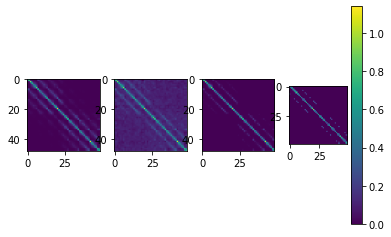

In [349]:
plt.subplot(1,4,1)
plt.imshow(C0)
plt.subplot(1,4,2)
plt.imshow(C)
plt.subplot(1,4,3)
plt.imshow(C1)
plt.subplot(1,4,4)
plt.imshow(C2)
plt.colorbar()

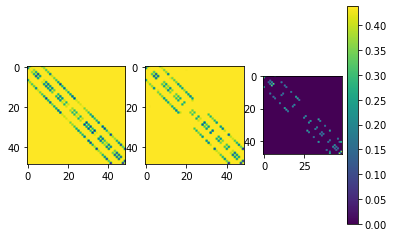

In [350]:
def remove_diag(M):
    return M - np.diag(np.diag(M))
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(P1))
plt.subplot(1,3,3)
plt.imshow(remove_diag(C2))
plt.colorbar()

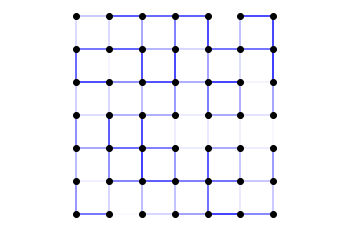

In [351]:
gh.dessin_graphe(P0,Vx,Vy)

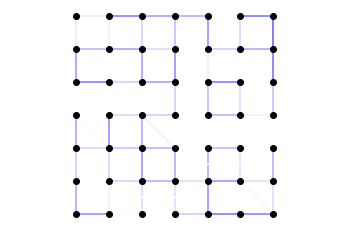

In [352]:
gh.dessin_graphe(P1,Vx,Vy)

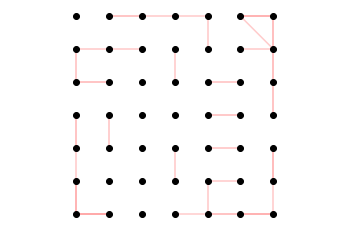

In [353]:
gh.dessin_graphe(C2,Vx,Vy)

# seuillage des éléments de la "presque" matrice de précision 

scoreL1 =  0.0014782281647478298
scoreL0 =  0.037067888379841735


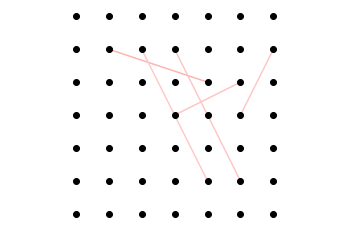

In [460]:
eps =1e-7
P3 = np.linalg.inv(C + eps*np.eye(num_vertices))  # car pb de non inversabilité de la matrice de corrélation C

t = 0.2
P3 = np.where(P3 > t, P3, 0.0)

scoreL1 = np.linalg.norm(P0-P3,1)/num_vertices**2
print("scoreL1 = ",scoreL1)

TP, FP, TN, FN = confusion_result(P0,P3) 
scoreL0 = (FP+FN)/num_vertices**2
print("scoreL0 = ",scoreL0)

gh.dessin_graphe(P3,Vx,Vy)

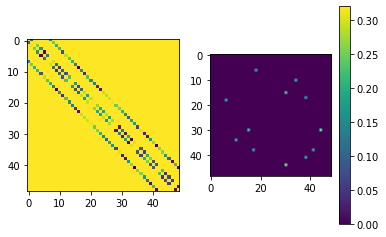

In [355]:
plt.subplot(1,2,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,2,2)
plt.imshow(remove_diag(P3))
plt.colorbar()

# m et n fixé, trouver meilleur lambda

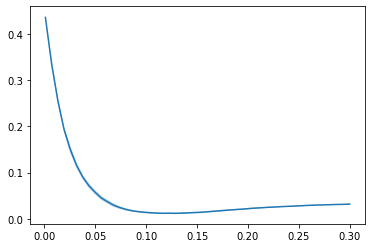

In [361]:
n = 500
score01 = []
L = list(np.linspace(1e-3,0.3,50))
nrep = 20 
for i in range(nrep):
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,n)).T
    C = X.T@X/n
    score = []
    for lamda in L:
        C1,P1 = skc.graphical_lasso(C,lamda)
        TP, FP, TN, FN = confusion_result(P0,P1) 
        score.append((FP+FN)/num_vertices**2)
    score01.append(score)

M = np.mean(score01, axis=0)  
S = np.std(score01, axis=0) 
plt.plot(L,M)
plt.fill_between(L,M-S, M+S ,alpha=0.3)

Meilleur $\lambda$ pour norme L0 pour $n = 500$ et $m = 49$: $\lambda = 0.12$

Meilleur $\lambda$ pour norme L0 pour $n = 1000$ et $m = 49$: $\lambda = 0.1$

Meilleur $\lambda$ pour norme L0 pour $n = 1e4$ et $m = 49$: $\lambda = 0.05$

Meilleur $\lambda$ pour norme L0 pour $n = 1e5$ et $m = 49$: $\lambda = 0.05$

# m fixé, trouver pour quel n on retrouve le graphe

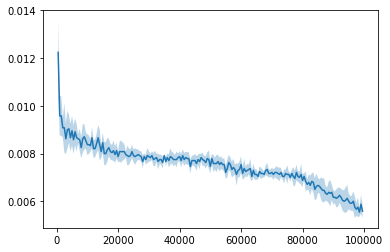

In [383]:
N =  list(range(500,100000,500))
L = list(np.linspace(0.12,0.03,500))
score01 = []
 
for i in range(len(N)):
    nrep = 10
    score = []
    for j in range(nrep):
        X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,N[i])).T
        C = X.T@X/N[i]
        C1,P1 = skc.graphical_lasso(C,L[i])
        TP, FP, TN, FN = confusion_result(P0,P1) 
        score.append((FP+FN)/num_vertices**2)
    score01.append(score)

M = np.mean(score01, axis=1)  
S = np.std(score01, axis=1) 
plt.plot(N,M)
plt.fill_between(N,M-S, M+S ,alpha=0.3)

# A faire

* tests sur tous les types de graphes

* graphical lasso avec cvxpt, rajouter contraintes Laplacien + article Dong (slides AST6 - 76 et 77)


In [13]:
def gen_precision(nom_graphe,num_vertices,correlation_min=.9,c=.5):
    A,Vx,Vy = gh.init_graph(nom_graphe,num_vertices)
    U = np.triu((1-correlation_min)*np.random.rand(num_vertices,num_vertices) + correlation_min)       
    Q = A*(U+U.T)     #matrice graphe pondéré
    L = np.diag(np.sum(Q, axis = 0)) - Q
    sigma = c*np.max(np.linalg.eigvals(L))
    P0 = L + sigma*np.eye(num_vertices) 
    return P0

In [14]:
def set_lambda_max(C0):
    la = 100
    u = 0
    it = 0
    while u<1e-3 and it<50:
        C1,P1 = skc.graphical_lasso(C0,la)
        u = np.linalg.norm(remove_diag(P1))
        it = it+1
        la = la*.8
    assert it!=50, "probleme dans la recherche de lambda_max"
    return la/.8

In [26]:
def repport_performance(P0,num_samples,nrep=10,nlambda=30,lmax=-1,type_score=0):
    num_vertices = P0.shape[0]
    C0 = np.linalg.inv(P0)
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
    C = X.T@X/num_samples   
    if lmax<0:
        lmax = set_lambda_max(C)
    lmin = lmax/1000
    list_score = []
    lambda_list = list(np.linspace(lmin,lmax,nlambda))
    for i in range(nrep):
        # on génére des va gaussiens de moyenne nulle et de matrice de covariance C0
        X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
        #covariance empirique des échantillons
        C = X.T@X/num_samples
        score = []
        for lamda in lambda_list:
            C1,P1 = skc.graphical_lasso(C,lamda)
            if type_score == 1:  #norme L1
                score.append(np.linalg.norm(P0-P1,1)/num_vertices**2)
            elif type_score == 0:
                TP, FP, TN, FN = confusion_result(P0,P1) 
                #sc_l0 = (FP+FN)/num_vertices**2
                nb_edge = np.sum( remove_diag(P0).flatten()!=0 ) # nombre d'arretes dans P0
                sc_l0 = (FP+FN)/nb_edge
                score.append(sc_l0)
        list_score.append(score)
    M = np.mean(list_score, axis=0)  
    S = np.std(list_score, axis=0) 
    return lambda_list, M, S

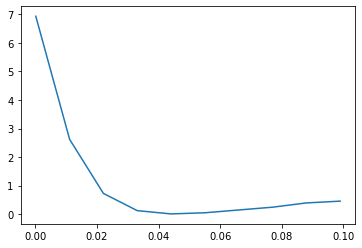

In [58]:
nom_graphe = "ligne"
num_vertices = 30
correlation_min = 1
c = .5
P0 = gen_precision(nom_graphe,num_vertices,correlation_min,c)
num_samples = 500
lambda_list, M, S = repport_performance(P0,num_samples,nrep=3,nlambda=10)
plt.plot(lambda_list,M)

In [59]:
 def plot_lambda_influ(nom_graphe,correlation_min,num_vertices,c,num_samples,nlambda=30,type_score=0,lmin=-1,lmax=-1,nrep=30,nom_figure=''):
        """trace score en fonction de lambda"""
        P0 = gen_precision(nom_graphe,num_vertices,correlation_min,c)
        lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda)
        plt.plot(lambda_list,M)
        plt.fill_between(lambda_list,M-S, M+S ,alpha=0.3)        
        plt.title("Graphe {0}, correlation_min = {1}, m = {2}, c = {3}, n = {4}".format(nom_graphe,correlation_min,num_vertices,c,num_samples))
        plt.xlabel("lambda")
        plt.ylabel("score L{0}".format(type_score))
        if nom_figure!='':
            plt.savefig(nom_figure)   

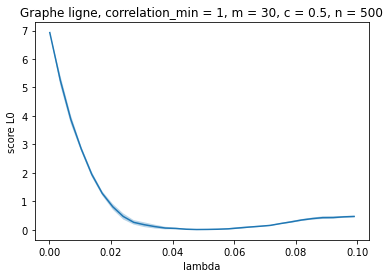

In [60]:
plot_lambda_influ(nom_graphe,correlation_min,num_vertices,c,num_samples,nrep=5)

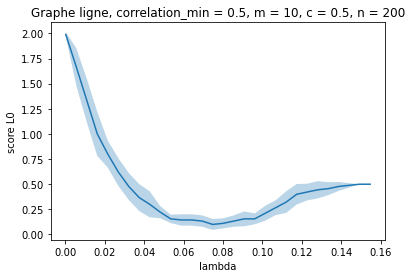

In [38]:
correlation_min = .5
plot_lambda_influ("ligne",correlation_min,num_vertices,c,num_samples,nrep=5)

In [67]:
nbr_N = 6
N_list =  np.linspace(40,500,nbr_N).astype(int)
nlambda = 20
nrep = 8
P0 = gen_precision(nom_graphe,num_vertices,correlation_min,c)
score_list = np.zeros(nbr_N)
std_list = np.zeros(nbr_N)
for j in range(len(N_list)):
    num_samples = N_list[j]
    lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda)
    score_list[j] = np.min(M)
    std_list[j] = S[ np.argmin(M) ]

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.528e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.538776243208977e-06, tolerance: 6.1299612837902276e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


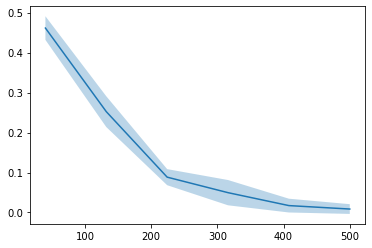

In [68]:
plt.plot(N_list,score_list)
plt.fill_between(N_list,score_list-std_list, score_list+std_list,alpha=0.3)   

In [524]:
def GL2(nom_graphe,correlation_min,num_vertices,c,list_N,type_score,list_lambda,nrep,nom_figure):
        """trace score en fonction de n dans N avec lambda dans list_lambda"""
        A,Vx,Vy = gh.init_graph(nom_graphe,num_vertices)

        U = np.triu((1-correlation_min)*np.random.rand(num_vertices,num_vertices) + correlation_min)       
        Q = A*(U+U.T)     #matrice graphe pondéré
        
        L = np.diag(np.sum(Q, axis = 0)) - Q

        sigma = c*np.max(np.linalg.eigvals(L))
        P0 = L + sigma*np.eye(num_vertices) 
        C0 = np.linalg.inv(P0)
        
        list_score = []
        
        for i in range(nrep):
            score = []
            for j in range(len(list_N)):
                num_samples = list_N[j]
                lamda = list_lambda[j]
                # on génére des va gaussiens de moyenne nulle et de matrice de covariance C0
                X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
                #covariance empirique des échantillons
                C = X.T@X/num_samples
                C1,P1 = skc.graphical_lasso(C,lamda)
                if type_score == 1:  #norme L1
                    score.append(np.linalg.norm(P0-P1,1)/num_vertices**2)
                elif type_score == 0:
                    TP, FP, TN, FN = confusion_result(P0,P1) 
                    score.append((FP+FN)/num_vertices**2)    
            list_score.append(score)

        M = np.mean(list_score, axis=0)  
        S = np.std(list_score, axis=0) 
        plt.plot(list_N,M)
        plt.fill_between(list_N,M-S, M+S ,alpha=0.3)
        
        plt.title("Graphe {0}, correlation_min = {1}, m = {2}, c = {3}".format(nom_graphe,correlation_min,num_vertices,c))
        plt.xlabel("num_samples")
        plt.ylabel("score L{0}".format(type_score))
        plt.savefig(nom_figure)

In [622]:
list_N = list(range(1000,100000,5000))
list_lambda = np.linspace(0.2,0.008,len(list_N))
GL2("grilleCarree",0,49,0.2,list_N,0,list_lambda,20,"GL_grille_score_enfct_N.png")
plt.plot(list_N,[0 for i in range(len(list_N))])

[]

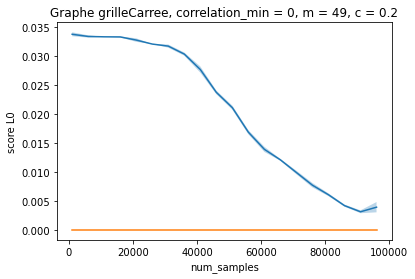

In [623]:
plt.plot()

In [600]:
list_N = list(range(1000,100000,5000))
list_lambda = [0.05 for i in range(len(list_N))]
GL2("ligne",0,10,0.2,list_N,0,list_lambda,20,"GL_ligne_score_enfct_N.png")
plt.plot(list_N,[0 for i in range(len(list_N))])

[]

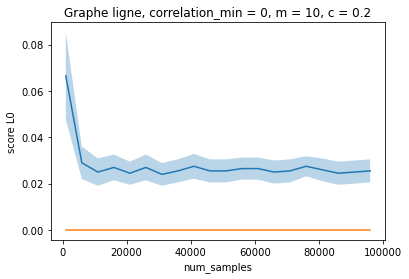

In [601]:
plt.plot()

In [606]:
list_N = list(range(1000,100000,5000))
list_lambda = [0.05 for i in range(len(list_N))]
GL2("cyclique",0,10,0.2,list_N,0,list_lambda,20,"GL_cyclique_score_enfct_N.png")
plt.plot(list_N,[0 for i in range(len(list_N))])

[]

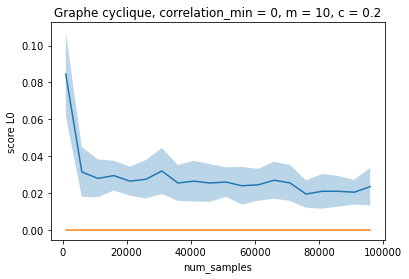

In [607]:
plt.plot()